# Exploratory Data Analysis

Author: Gillian A. McGinnis, final-semester M.S. Information Science - Machine Learning  
The University of Arizona College of Information  
INFO 698 - Capstone  
Start date: 24 September 2025  
Last updated: 30 November 2025

In [2]:
"""
Module providing supporting code and generating all images/tables for EDA.
"""

'\nModule providing supporting code and generating all images/tables for EDA.\n'

## Load Required Libraries

In [3]:
# General packages
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For time series data management
# import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import datetime as dt
# import pyarrow as pa

# For data importing
from helper_utils import get_path

In [4]:
## (Optional chunk)
# Current session information
import session_info
session_info.show(dependencies=False)

## Import

In [5]:
# Runoff, rain, and calibration data
data_water = pd.read_parquet(get_path('clean/water.parquet'))
# Soil sample data
data_soil = pd.read_parquet(get_path('clean/soil.parquet'))

## Exploration

### General Variables

In [6]:
# Explore weir combined data, comments, etc.
print(
    "-----Data types-----", data_water.dtypes,
    "\n-----Source-----", data_water['source_ro'].value_counts(dropna = False),
    "\n-----Notes-----", data_water['chk_note_ro'].value_counts(dropna = False),
    "\n-----Comments-----", data_water['comment_ro'].value_counts(dropna = False),
    "\n-----Fail mode-----", data_water['chk_fail_ro'].value_counts(dropna = False),
    sep="\n"
)

-----Data types-----
weir_level_cal          Int8
ra_rain              float32
raw_rain             float32
chk_note_rain       category
chk_fail_rain       category
level_ro             float32
raw_ro               float32
chk_note_ro         category
chk_fail_ro         category
comment_ro          category
source_ro           category
obstruction_ro       boolean
gap_fill_ro          boolean
weir_cleaning_ro     boolean
spike_ro             boolean
calibration_ro       boolean
dtype: object

-----Source-----
source_ro
ISCO         1656120
CHART+AF      752435
RADAR         618896
NaN           472944
TROLL           1428
ESTIMATED        290
CHART              0
Name: count, dtype: int64

-----Notes-----
chk_note_ro
good        2455819
adjusted     691532
nc           325847
NaN           28914
bad               1
missing           0
Name: count, dtype: int64

-----Comments-----
comment_ro
NaN                                                                         3502097
Data missi

### Visualization

Code for creating plots for the poster and writeup.

#### Failure Modes

Visualizing the various failure modes by plotting the raw runoff values against the adjusted ones, with calibration points and rain if applicable.
The style of these is inspired by that of the original Visual FoxPro interface method currently in use.

In [7]:
def plot_between(input_date_start, input_date_end, include_calibration=True, include_legend=True, include_baseline=True, include_rainaxis = False, shrink_plot=False):
    """Plot values between two dates in the style of the Visual FoxPro interface.

    Args:
        input_date_start (Timestamp): The start date.
        input_date_end (Timestamp): The end date.
        include_calibration (bool): Include X-markers for the calibration points.
        include_legend (bool): Include a legend of different elements.
        include_baseline (bool): Include a baseline of 0; sets to True if rain occurred.
        include_rainaxis (bool): Add a secondary y-axis for rain values.
        shrink_plot (bool): Output a small plot; useful for posters.
    
    Returns:
        Time series plot.
    """

    # Filter the data sets
    data_subset = data_water[input_date_start:input_date_end].copy()
    
    if shrink_plot == True:
        fig, ax = plt.subplots(figsize=(5, 3))
        include_legend = False
        include_rainaxis = False
    else:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Keep track of the number of plotted elements, for adding a legend
    plotted_elements = 0

    # Add a baseline of 0 if selected, or if rain occurs at any point
    if include_baseline == True or data_subset['ra_rain'].notna().any():
        plt.axhline(y = 0, color ='lightgrey')

    # If rain occurs
    if data_subset['ra_rain'].notna().any():
        rain_label = 'Rain (x3)'
        # Initialize secondary axis
        if include_rainaxis == True:
            def p_to_s(value):
                return value*3

            def s_to_p(value):
                return value/3

            secax_y = ax.secondary_yaxis('right', functions=(p_to_s, s_to_p))
            secax_y.set_ylabel('Rain (mm)', color='blue')
            secax_y.tick_params(colors='blue')
            rain_label = 'Rain'
        # Plot the rain as a bar chart with a multiplier for visibility
        ax.vlines(
            data_subset.index,
            ymin = 0,
            ymax = data_subset['ra_rain']*3,
            color = 'blue',
            label = rain_label
        )
        plotted_elements += 1

    # If ALL values of raw runoff match the adjusted, do not plot adjusted values
    if (all(data_subset['raw_ro'] == data_subset['level_ro']) == False):
        ax.plot(
            data_subset.index,
            data_subset['level_ro'],
            color = 'red',
            label = "Adjusted"
        )
        plotted_elements += 1

    # Plot raw runoff values
    if shrink_plot == False:
        ax.plot(
            data_subset.index,
            data_subset['raw_ro'],
            color = 'green',
            label = "Raw"
        )
        plotted_elements += 1
    
    # Include calibration points if specified, unless there are none in the subset
    if include_calibration == True and data_subset['weir_level_cal'].notna().any():
        # Make marker small if mini plot
        if shrink_plot == True:
            ax.plot(
                data_subset.index,
                data_subset['weir_level_cal'],
                linestyle='none',
                marker='x',
                color='orange',
                label = "Calibration",
                markersize = 5
            )
        # Plot calibration points
        ax.plot(
            data_subset.index,
            data_subset['weir_level_cal'],
            linestyle = 'none',
            marker = 'x',
            color = 'orange',
            label = "Calibration"
        )
        plotted_elements += 1
    
    # # Plot raw runoff values
    # # in front of calibration values
    if shrink_plot == True:
        ax.plot(
            data_subset.index,
            data_subset['raw_ro'],
            color = 'green',
            label = "Raw"
        )
        plotted_elements += 1

    # Plot labels and settings
    ax.set_ylabel("Runoff (mm)")
    if shrink_plot == False:
        ax.set_xlabel("Date (YYYY-MM-DD)")
        ax.set_title(f"Runoff time series from {data_subset.index.min()} through {data_subset.index.max()}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Add a legend if specified and if there are enough elements to justify it
    if include_legend == True and plotted_elements >= 2:
        # Reverse the order of the legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc='upper right')
    
    return plt

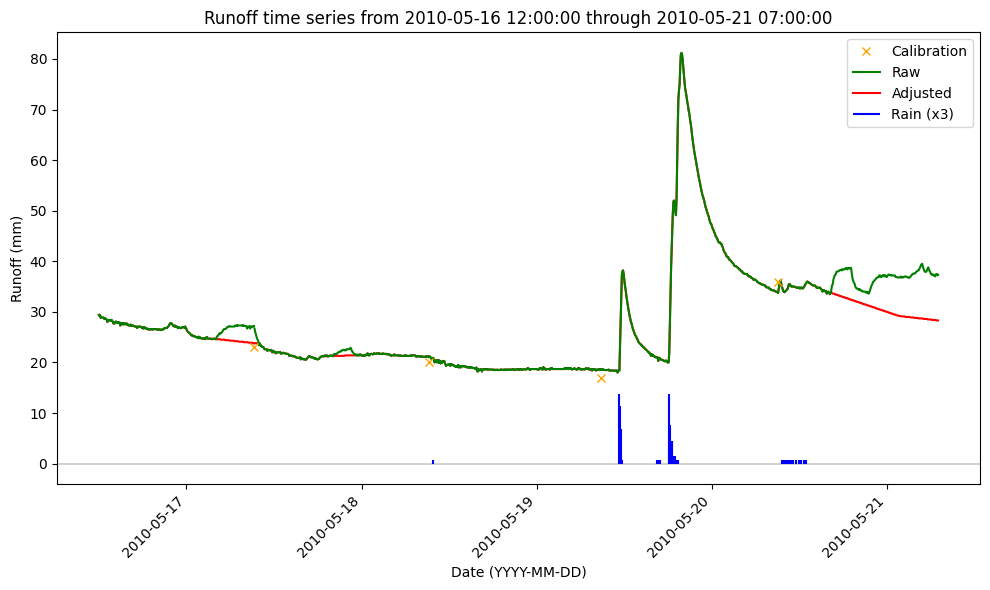

In [8]:
# Large plot
# for the legend
viz_leg = plot_between('2010-05-16 12:00:00','2010-05-21 07:00:00')
# plot_between('2010-05-16 12:00:00','2010-05-21 07:00:00', include_rainaxis=False).savefig(get_path('figures/poster_legend.png', 'outputs'))
viz_leg.savefig(get_path('figures/poster_legend.png', 'outputs'))
del viz_leg

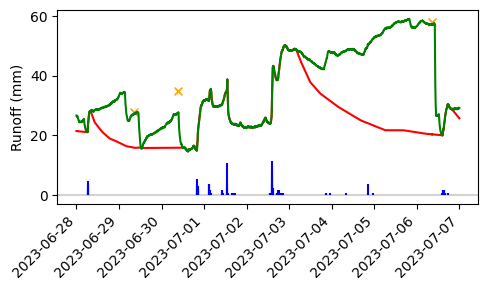

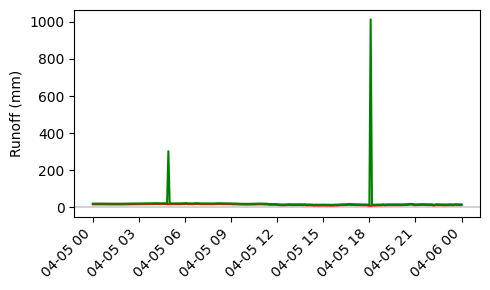

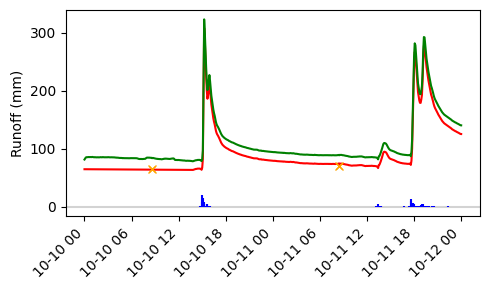

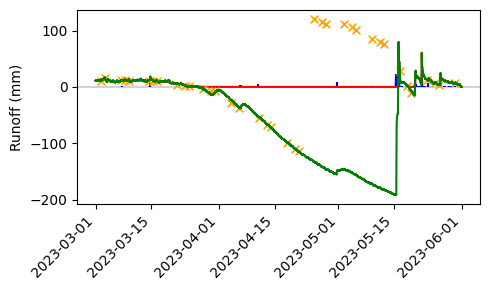

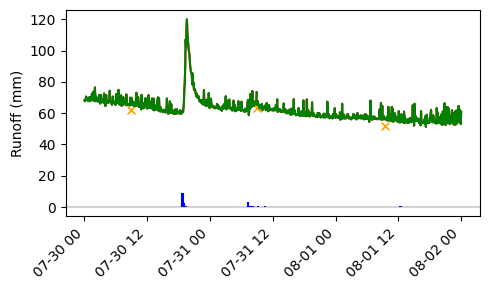

In [9]:
# # # Blockage
# viz_block = plot_between('2025-02-27 05:00:00', '2025-02-28 12:00:00', shrink_plot = True)
viz_block = plot_between('2023-06-28 00:00:00', '2023-07-07 00:00:00', shrink_plot = True)
viz_block.savefig(get_path('figures/poster_block.png', 'outputs'))
# viz_block.show()

# # # Spike
viz_spike = plot_between('2021-04-05 00:00:00', '2021-04-06 00:00:00', shrink_plot=True)
viz_spike.savefig(get_path('figures/poster_spike.png', 'outputs'))
# viz_spike.show()

# # Calibration
viz_cal = plot_between('2018-10-10 00:00:00', '2018-10-12 00:00:00', shrink_plot=True)
viz_cal.savefig(get_path('figures/poster_cal.png', 'outputs'))
# viz_cal.show()

# # # Sub-zero
viz_subz = plot_between('2023-03-01 00:00:00', '2023-06-01 00:00:00', shrink_plot=True)
viz_subz.savefig(get_path('figures/poster_subz.png', 'outputs'))
# viz_subz.show()

# # # Noise
viz_noise = plot_between('2002-07-30 00:00:00', '2002-08-02 00:00:00', shrink_plot=True)
viz_noise.savefig(get_path('figures/poster_noise.png', 'outputs'))
# viz_noise.show()

### Statistics

In [10]:
def name_clean_col(input_df, index_name = None):
    output_df = input_df
    output_df.columns = output_df.columns.str.replace(r'_(ro)$', '', regex=True)
    output_df.columns = output_df.columns.str.replace(r'_', ' ', regex=True)
    output_df.columns = output_df.columns.str.title()
    if index_name is not None:
        output_df = output_df.reset_index(names=index_name)
    return output_df

def name_clean_row(input_df, index_name=None):
    output_df = input_df
    output_df.index = output_df.index.str.replace(r'_(ro)$', '', regex=True)
    output_df.index = output_df.index.str.replace(r'_', ' ', regex=True)
    output_df.index = output_df.index.str.title()
    if index_name is not None:
        output_df = output_df.reset_index(names=index_name)
    return output_df

In [11]:
def make_latex_tab(input_tab, input_name, incl_index = False):
    """Export data frame to LaTeX-compatible table.

    Args:
        input_tab (pd.DataFrame): The table to convert.
        input_name (str): File name and internal label.
        incl_index (bool, optional): Whether to include the index. Defaults to False.
    
    Returns:
        None; saves file to tables sub-folder in outputs folder in home directory of repo.
    """
    loc_path = 'tables/' + input_name + '.tex'
    input_tab.to_latex(buf = get_path(loc_path, 'outputs'), index=incl_index, label=input_name)
    return

In [12]:
# Failure mode insights
data_fm = data_water.copy()[['obstruction_ro', 'gap_fill_ro', 'weir_cleaning_ro', 'spike_ro', 'calibration_ro']].sum()
data_fm = data_fm.to_frame(name='Count')
data_fm['Percentage'] = round((data_fm['Count']/len(data_water))*100, 2)
data_fm = data_fm.sort_values(by='Percentage', ascending=False)

# Name cleanup
data_fm = name_clean_row(data_fm, "Type")
# data_fm.index = data_fm.index.str.replace(r'_(ro)$', '', regex=True)
# data_fm.index = data_fm.index.str.replace(r'_', ' ', regex=True)
# data_fm.index = data_fm.index.str.title()

# Set index to its own column
# data_fm = data_fm.reset_index(names="Type")

# Improve formatting for readability
data_fm['Count'] = data_fm['Count'].map('{:,}'.format)
data_fm['Percentage'] = data_fm['Percentage'].map('{:.2f}%'.format)

make_latex_tab(data_fm, 'tab_errorcounts')
data_fm

,Type,Count,Percentage
0,Calibration,"356,282",10.17%
1,Obstruction,"323,262",9.23%
2,Gap Fill,"10,726",0.31%
3,Spike,"4,841",0.14%
4,Weir Cleaning,"4,295",0.12%


In [ ]:
# data_fm_yr = data_water[['obstruction', 'gap_fill', 'weir_cleaning', 'spike', 'calibration']].resample('1YE').sum()
# data_fm_yr
data_fm_yr_e = data_water[['obstruction_ro', 'gap_fill_ro', 'weir_cleaning_ro', 'spike_ro', 'calibration_ro']].resample('1YE').sum()
data_fm_yr_cnt = data_water['level_ro'].resample('1YE').count()
# data_fm_yr = pd.concat([data_fm_yr_cnt, data_fm_yr], axis=1)
data_fm_yr = pd.concat([data_fm_yr_cnt, data_fm_yr_e], axis=1)
del data_fm_yr_e, data_fm_yr_cnt

data_fm_yr = data_fm_yr.rename(columns={'level_ro':'Count'})


data_fm_yr = name_clean_col(data_fm_yr, "Year")
data_fm_yr["Year"] = data_fm_yr["Year"].dt.year

# Make a copy for another table in the next block
data_fm_yr_per = data_fm_yr.copy()

# Add commas to all values except the year
for col in data_fm_yr:
    if col!="Year":
        data_fm_yr[col] = data_fm_yr[col].map('{:,}'.format)

# Add an empty column to add another line between the total counts and error counts
data_fm_yr.insert(loc=2, column = ' ', value = '')

make_latex_tab(data_fm_yr, "tab_fmyear_counts")
data_fm_yr

,Year,Count,,Obstruction,Gap Fill,Weir Cleaning,Spike,Calibration
0,1989,"46,331",,0,0,0,0,0
1,1990,"105,120",,"1,954",0,0,0,0
2,1991,"105,119",,"1,514",0,0,0,0
3,1992,"105,138",,"2,833",0,0,0,0
4,1993,"103,065",,"2,132",0,0,0,0
5,1994,"103,930",,"1,086",0,0,0,"8,251"
6,1995,"104,558",,0,0,0,94,"23,563"
7,1996,"89,112",,0,0,0,0,"70,148"
8,1997,"90,115",,"2,179","5,947",0,68,"14,121"
9,1998,"105,120",,653,0,0,15,0


In [ ]:
for col in data_fm_yr_per:
    if col!="Year" and col!="Count":
        data_fm_yr_per[col] = (data_fm_yr_per[col]/data_fm_yr_per['Count']).multiply(100,axis=0)
        data_fm_yr_per[col] = data_fm_yr_per[col].map('{:.2f} %'.format)

data_fm_yr_per = data_fm_yr_per.replace('0.00 %', '-')
data_fm_yr_per['Count'] = data_fm_yr_per['Count'].map('{:,}'.format)

# Add an empty column to add another line between the total counts and error counts
data_fm_yr_per.insert(loc=2, column = ' ', value = '')

make_latex_tab(data_fm_yr_per, "tab_fmyear_pers")
data_fm_yr_per

,Year,Count,Obstruction,Gap Fill,Weir Cleaning,Spike,Calibration
0,1989,"46,331",-,-,-,-,-
1,1990,"105,120",1.86 %,-,-,-,-
2,1991,"105,119",1.44 %,-,-,-,-
3,1992,"105,138",2.69 %,-,-,-,-
4,1993,"103,065",2.07 %,-,-,-,-
5,1994,"103,930",1.04 %,-,-,-,7.94 %
6,1995,"104,558",-,-,-,0.09 %,22.54 %
7,1996,"89,112",-,-,-,-,78.72 %
8,1997,"90,115",2.42 %,6.60 %,-,0.08 %,15.67 %
9,1998,"105,120",0.62 %,-,-,0.01 %,-


In [ ]:
# data_water[data_water['chk_fail'].str.contains("Weir", na=False)]
# data_water['2021-04-12 00:00:00':'2021-04-12 23:59:59']
# data_water[data_water['chk_fail'].str.contains("Obs", na=False)]
# plot_between("2024-06-30 12:00:00", "2024-06-30 18:59:59")

In [ ]:
#Failure Mode count plot

fig, ax = plt.subplots(figsize=(10, 6))
## Line for 0
plt.axhline(y=0, color = "grey", linestyle = ":")
plt.grid(axis = 'x', which = 'major')
plt.xticks(rotation = 90)
# ax.set_yscale('log', base=2)
# Mean
ax.plot(data_fm_yr_per.index, data_fm_yr_per['obstruction']/10, label="Obs")
ax.plot(data_fm_yr_per.index, data_fm_yr_per['gap_fill'], label="GF")
ax.plot(data_fm_yr_per.index, data_fm_yr_per['weir_cleaning']*2, label="WC")
ax.plot(data_fm_yr_per.index, data_fm_yr_per['spike']*2, label="Sp")
ax.plot(data_fm_yr_per.index, data_fm_yr_per['calibration']/10, label="Cal")

# ax.plot(data_fm_yr_per.index, data_fm_yr_per['obstruction'], label="Obs")
# ax.plot(data_fm_yr_per.index, data_fm_yr_per['calibration'], label="Cal")

# plt.axhline(y=0, color = "grey", linewidth=3)
ax.set_xlabel("Year")
ax.set_ylabel("Percentage")
ax.set_title("Percentage of values with FMs")
# ax.set_ylim(bottom = 0)
# ax.set_xlim(left = dt.date(1989, 1, 1), right = dt.date(2026, 1, 1))
# ax.set_xlim(left = dt.date(1989, 1, 1), right = dt.date(2026, 1, 1))
# ax.xaxis.set_major_locator(mdates.YearLocator(month = 1)) # Show ticks at start of year
# plt.xticks(rotation = 90)
plt.tight_layout()
# plt.grid(axis = 'x', which = 'major')
plt.legend(loc = 'upper right')
# Truncate plot
# ax.set_ylim(bottom = 0, top = 250)
# ax.set_ylim(bottom = 0, top = 10)

plt.show()

del fig, ax

In [ ]:
# Source insights
# data_water.groupby('source', dropna=False, observed=True)['raw'].agg(['count','mean', 'std', 'min', 'max'])

In [ ]:
# time_series = pd.Series(data_water, index='datetime')
# time_series
# pd.DatetimeIndex.to_series(data_water)
# time_series = pd.to_datetime(data_water.index())

# data_sumstats = data_water['raw'].dropna().resample('1YE').agg(['mean','std', 'min', 'max']).dropna()
# data_sumstats

# # Removing values below 0
# data_sumstats = data_water[data_water['raw'] >= 0]
# Get yearly stats
data_sumstats_yr = data_water['raw_ro'].copy().dropna().resample('1YE').agg(['count', 'mean','std', 'min', 'max'])
# Get monthly averages and std
data_sumstats = data_water['raw_ro'].dropna().resample('1ME').agg(['mean','std'])

# Simplifying datetime to the year for readability
data_sumstats_yr = data_sumstats_yr.reset_index()
data_sumstats_yr['year'] = data_sumstats_yr['datetime'].dt.year
data_sumstats_yr = data_sumstats_yr.set_index('year').drop('datetime', axis=1)
data_sumstats_yr

In [35]:
data_sumstats_adj = data_water['level_ro'].dropna().resample('1ME').agg(['mean','std'])

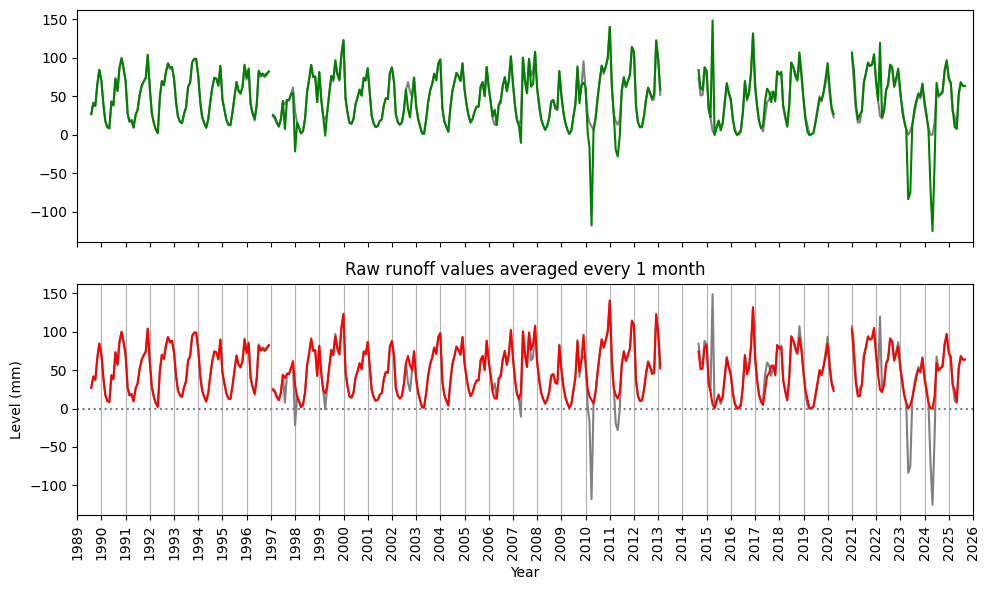

In [ ]:
## Plotting both, highlighting one at a time
# #Running avg plot

# fig, axs = plt.subplots(figsize=(10, 6), nrows=2, ncols=1, sharex=True, sharey=True)
# ## Line for 0
# plt.axhline(y=0, color = "grey", linestyle = ":")
# # Mean
# axs[0].plot(data_sumstats_adj.index, data_sumstats_adj['mean'], color='grey')
# axs[0].plot(data_sumstats.index, data_sumstats['mean'], color = 'green')

# axs[1].plot(data_sumstats.index, data_sumstats['mean'], color = 'grey')
# axs[1].plot(data_sumstats_adj.index, data_sumstats_adj['mean'], color='red')
# # ax.plot(data_sumstats.index, data_sumstats['mean'], color = 'green', label = "Mean")
# # Ribbon for standard deviation
# # ax.fill_between(data_sumstats.index, data_sumstats['mean']-data_sumstats['std'], data_sumstats['mean']+data_sumstats['std'], color = 'aquamarine', label = "std")
# axs[1].set_xlabel("Year")
# axs[1].set_ylabel("Level (mm)")
# axs[1].set_title("Raw runoff values averaged every 1 month")
# # ax.set_ylim(bottom = 0)
# axs[1].set_xlim(left = dt.date(1989, 1, 1), right = dt.date(2026, 1, 1))
# axs[1].xaxis.set_major_locator(mdates.YearLocator(month = 1)) # Show ticks at start of year
# plt.xticks(rotation = 90)
# plt.tight_layout()
# plt.grid(axis = 'x', which = 'major')
# # plt.legend(loc = 'upper right')
# # Truncate plot
# # ax.set_ylim(bottom = 0, top = 250)

# plt.show()

# del fig, axs

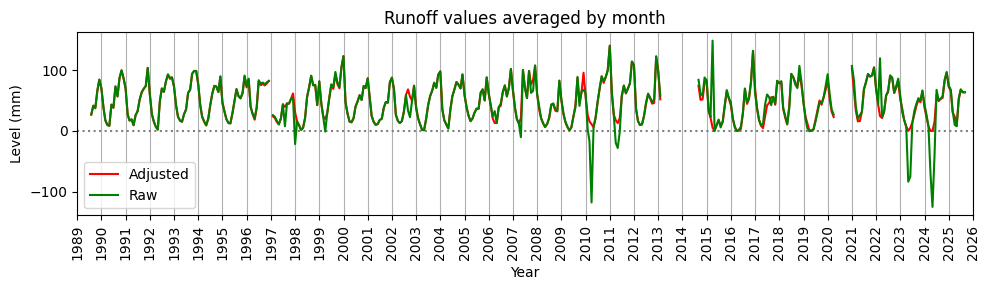

In [98]:
#Running avg plot

fig, ax = plt.subplots(figsize=(10, 3))
## Line for 0
plt.axhline(y=0, color = "grey", linestyle = ":")
# Mean
ax.plot(data_sumstats_adj.index, data_sumstats_adj['mean'], color='red', label="Adjusted")
ax.plot(data_sumstats.index, data_sumstats['mean'], color = 'green', label="Raw")
# ax.plot(data_sumstats.index, data_sumstats['mean'], color = 'green', label = "Mean")
# Ribbon for standard deviation
# ax.fill_between(data_sumstats.index, data_sumstats['mean']-data_sumstats['std'], data_sumstats['mean']+data_sumstats['std'], color = 'aquamarine', label = "std")
ax.set_xlabel("Year")
ax.set_ylabel("Level (mm)")
ax.set_title("Runoff values averaged by month")
# ax.set_ylim(bottom = 0)
ax.set_xlim(left = dt.date(1989, 1, 1), right = dt.date(2026, 1, 1))
ax.xaxis.set_major_locator(mdates.YearLocator(month = 1)) # Show ticks at start of year
plt.xticks(rotation = 90)
plt.tight_layout()
plt.grid(axis = 'x', which = 'major')
plt.legend(loc = 'lower left')
# Truncate plot
# ax.set_ylim(bottom = 0, top = 250)

plt.show()

del fig, ax

In [ ]:
## Average -- daily
# data_sumstats_da = data_water.copy()['level_ro']
# data_sumstats_da = data_sumstats_da.dropna().resample('1D').agg(['mean','std'])
# data_sumstats_da['year'] = data_sumstats_da.index.year
# data_sumstats_da['day'] = data_sumstats_da.index.day_of_year

# fig, ax = plt.subplots(figsize=(10, 3))
# # fig, axs = plt.subplots(2, 1, figsize=(5, 8), subplot_kw={'projection': 'polar'},
#                         # layout='constrained')
# # ax = axs[0]
# ## Line for 0
# plt.axhline(y=0, color = "grey", linestyle = ":")
# # Mean
# for yr in data_sumstats_da['year'].unique():
#     data_subset = data_sumstats_da[data_sumstats_da['year'] == yr]
#     # ax.plot(data_sumstats_da[data_sumstats_da['year']==yr].index.day, data_sumstats_da[data_sumstats_da['year']==yr]['mean'], color = 'green')
#     ax.plot(data_subset.index.day_of_year, data_subset['mean'], color = 'green')
# # ax.plot(data_sumstats.index, data_sumstats['mean'], color = 'green', label = "Mean")
# # Ribbon for standard deviation
# # ax.fill_between(data_sumstats.index, data_sumstats['mean']-data_sumstats['std'], data_sumstats['mean']+data_sumstats['std'], color = 'aquamarine', label = "std")
# ax.set_xlabel("Month")
# ax.set_ylabel("Level (mm)")
# ax.set_title("Average raw values every 1mo")
# # ax.set_ylim(bottom = 0)
# # ax.set_xlim(left = dt.date(1989, 1, 1), right = dt.date(2026, 1, 1))
# # ax.xaxis.set_major_locator(mdates.YearLocator(month = 1)) # Show ticks at start of year
# plt.xticks(rotation = 90)
# plt.tight_layout()
# plt.grid(axis = 'x', which = 'major')
# # plt.legend(loc = 'upper right')
# # Truncate plot
# # ax.set_ylim(bottom = 0, top = 250)

# plt.show()

# del fig, ax, yr, data_subset#, axs

In [ ]:
# #Running avg plot -- monthly
# data_sumstats['month'] = data_sumstats.index.month
# data_sumstats['year'] = data_sumstats.index.year
# # data_sumstats.index.year.unique()
# fig, ax = plt.subplots(figsize=(10, 3))
# # fig, axs = plt.subplots(2, 1, figsize=(5, 8), subplot_kw={'projection': 'polar'},
#                         # layout='constrained')
# # ax = axs[0]
# ## Line for 0
# plt.axhline(y=0, color = "grey", linestyle = ":")
# # Mean
# for yr in data_sumstats['year'].unique():
#     ax.plot(data_sumstats[data_sumstats['year']==yr].index.month, data_sumstats[data_sumstats['year']==yr]['mean'], color = 'green')
# # ax.plot(data_sumstats.index, data_sumstats['mean'], color = 'green', label = "Mean")
# # Ribbon for standard deviation
# # ax.fill_between(data_sumstats.index, data_sumstats['mean']-data_sumstats['std'], data_sumstats['mean']+data_sumstats['std'], color = 'aquamarine', label = "std")
# ax.set_xlabel("Month")
# ax.set_ylabel("Level (mm)")
# ax.set_title("Average raw values every 1mo")
# # ax.set_ylim(bottom = 0)
# # ax.set_xlim(left = dt.date(1989, 1, 1), right = dt.date(2026, 1, 1))
# # ax.xaxis.set_major_locator(mdates.YearLocator(month = 1)) # Show ticks at start of year
# plt.xticks(rotation = 90)
# plt.tight_layout()
# plt.grid(axis = 'x', which = 'major')
# # plt.legend(loc = 'upper right')
# # Truncate plot
# # ax.set_ylim(bottom = 0, top = 250)

# plt.show()

# del fig, ax, yr#, axs

In [61]:
data_sumstats_soil = data_soil.copy()[['h2o_by_wet_shallow', 'h2o_by_wet_deep']]
data_sumstats_soil = data_sumstats_soil.dropna().resample('1ME').agg(['mean','std'])
# data_sumstats_soil['year'] = data_sumstats_da.index.year
# data_sumstats_soil['day'] = data_sumstats_da.index.day_of_year
# data_sumstats_soil['month'] = data_sumstats_soil.index.month
# data_sumstats_soil

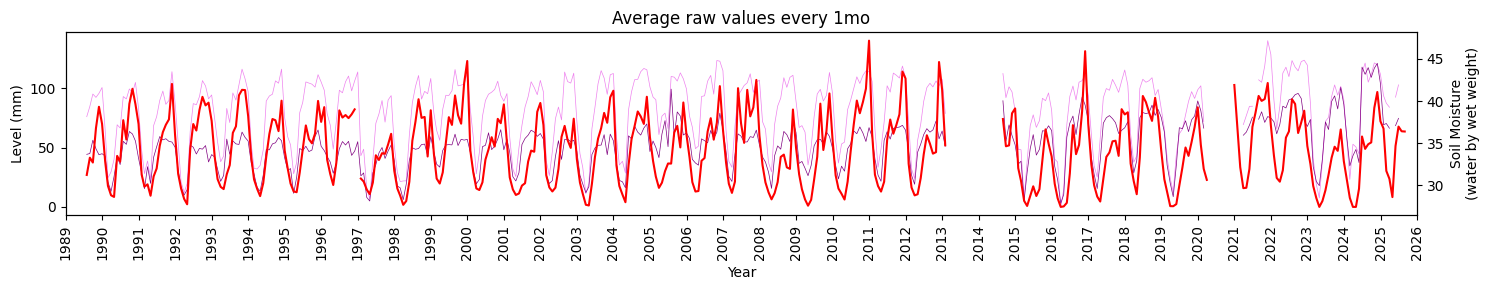

In [77]:
#Running avg plot

fig, ax = plt.subplots(figsize=(15, 3))
## Line for 0
# plt.axhline(y=0, color = "grey", linestyle = ":")
# Mean
# ax.plot(united_soil_mini.index, united_soil_mini['h2o_by_wet_shallow'], color = 'pink')
# ax.plot(united_soil_mini.index, united_soil_mini['h2o_by_wet_deep'], color = 'purple')

ax2 = ax.twinx()

# # ## Plot all samples separatley
# # zord = 1
# for category, group_df in data_soil.groupby('sample', observed=True):
#     # ax2.plot(group_df.index, group_df['h2o_by_wet_shallow'], label=category, alpha=0.5, color='orange', linewidth = 0.25, zord = 1)
#     ax2.plot(group_df.index, group_df['h2o_by_wet_shallow'], label=category, alpha=0.75, color='violet', linewidth = 0.25)
#     # zord += 1
# # for category, group_df in united_soil_mini.groupby('sample'):
#     ax2.plot(group_df.index, group_df['h2o_by_wet_deep'], label=category, alpha=0.75, color='purple', linewidth = 0.25)
#     # zord += 1

ax2.plot(data_sumstats_soil.index, data_sumstats_soil['h2o_by_wet_shallow']['mean'], label="Shallow", color='violet', linewidth = 0.5)
ax2.plot(data_sumstats_soil.index, data_sumstats_soil['h2o_by_wet_deep']['mean'], label="Deep", color='purple', linewidth = 0.5)

# ax.plot(data_sumstats.index, data_sumstats['mean'], color = 'green', zorder = zord)
ax.plot(data_sumstats_adj.index, data_sumstats_adj['mean'], color = 'red')

# ax.plot(data_sumstats.index, data_sumstats['mean'], color = 'green', label = "Mean")
# Ribbon for standard deviation
# ax.fill_between(data_sumstats.index, data_sumstats['mean']-data_sumstats['std'], data_sumstats['mean']+data_sumstats['std'], color = 'aquamarine', label = "std")
ax.set_xlabel("Year")
ax.set_ylabel("Level (mm)")
ax2.set_ylabel("Soil Moisture\n(water by wet weight)")
ax.set_title("Average raw values every 1mo")
# ax.set_ylim(bottom = 0)
ax.set_xlim(left = dt.date(1989, 1, 1), right = dt.date(2026, 1, 1))
ax.xaxis.set_major_locator(mdates.YearLocator(month = 1)) # Show ticks at start of year
plt.xticks(rotation = 90)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.grid(axis = 'x', which = 'major')
# plt.legend(loc = 'upper right')
# Truncate plot
# ax.set_ylim(bottom = 0, top = 250)

# Set moisture plot to back
ax2.set_zorder(1)
# Set mean line to be in front
ax.set_zorder(2)
# Change background of mean line plot transparent
ax.patch.set_visible(False)

plt.show()

del fig, ax, ax2#, category, group_df#, zord

In [ ]:
# # united_soil[('h2o_by_wet_shallow', 'h2o_by_wet_deep')]#.resample('1YE').agg(['mean', 'std'])
# # united_sumstats_soil = pd.DataFrame()
# # united_sumstats_soil = united_soil['h2o_by_wet_shallow'].dropna().resample('1YE').mean()
# # united_sumstats_soil['h2o_by_wet_deep'] = united_soil['h2o_by_wet_deep'].dropna().resample('1YE').mean()
# # united_sumstats_soil
# # united_soil.groupby('sample')
# # united_soil['h2o_by_wet_shallow'].dropna().resample('1YE').mean()
# # united_soil
# # united_soil_test = united_soil.groupby('sample')
# united_soil_test = united_soil[['sample', 'h2o_by_wet_shallow']]
# # united_soil.resample('1YE')['h2o_by_wet_shallow'].dropna().mean()
# # united_soil_test.groupby('sample').resample('1YE').mean()#.dropna().mean()
# print(united_soil_test.groupby('sample').resample('1YE').mean())

# # # Removing values below 0
# # data_sumstats = data_water[data_water['raw'] >= 0]
# # # Get yearly averages and std
# # data_sumstats_yr = data_sumstats['raw'].dropna().resample('1YE').agg(['count', 'mean','std', 'min', 'max'])
# # # Get monthly averages and std
# # data_sumstats = data_sumstats['raw'].dropna().resample('1ME').agg(['mean','std'])

# # # Simplifying datetime to the year for readability
# # data_sumstats_yr = data_sumstats_yr.reset_index()
# # data_sumstats_yr['year'] = data_sumstats_yr['datetime'].dt.year
# # data_sumstats_yr = data_sumstats_yr.set_index('year').drop('datetime', axis=1)
# # print(data_sumstats_yr)

In [ ]:
# united_soil['2020-01-01 00:00:00':'2021-12-31 23:59:59']
united_water['1996-11-01 00:00:00':'1997-01-31 23:59:59']
# 1996-11-05 12:10:00 -- 1997-01-29 08:34:00

## Export

In [ ]:
# print(get_data_path('clean/water.parquet'))
# united_soil.to_parquet(get_data_path('clean/TEST.parquet'))

In [ ]:
# united_water.to_parquet('data/clean/water.parquet')
# united_soil.to_parquet('data/clean/soil.parquet')

united_water.to_parquet(get_data_path('clean/water.parquet'))
united_soil.to_parquet(get_data_path('clean/soil.parquet'))

In [ ]:
# data_calibration.to_parquet('data/clean/calibration.parquet')
data_calibration.to_parquet(get_data_path('clean/calibration.parquet'))
united_waternocal = pd.merge(data_rainfall.add_suffix("_rain"), data_water.add_suffix("_ro"), left_index=True, right_index=True, how='outer')
united_waternocal.to_parquet(get_data_path('clean/water_nocal.parquet'))
# united_waternocal.to_parquet('data/clean/water_nocal.parquet')